In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

import os
from sklearn.metrics import silhouette_score
import umap

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [0]:
# !pip install -U sentence-transformers

In [0]:
from sentence_transformers import SentenceTransformer

In [27]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_path = os.path.join('gdrive', 'My Drive', 'Colab Notebooks', 'text_clustering', 'million-headlines', 'abcnews-date-text.csv')

In [29]:
# dataframe
df_all = pd.read_csv(data_path)

# get year from date and put that in a new column "year"
df_all['year'] = df_all['publish_date'].apply(lambda s: str(s)[:4])

print('shape of dataframe:', df_all.shape)

shape of dataframe: (1103663, 3)


In [30]:
print('number of news headlines in different years:')
print(df_all.groupby('year')['year'].count())

number of news headlines in different years:
year
2003    64003
2004    72674
2005    73124
2006    66912
2007    77192
2008    80014
2009    76454
2010    74948
2011    77829
2012    89109
2013    92337
2014    82330
2015    77941
2016    54614
2017    44182
Name: year, dtype: int64


In [31]:
# get news headlines from 2017 only
df = df_all.loc[df_all['year'] == "2017"]

print('shape of dataframe:', df.shape)

shape of dataframe: (44182, 3)


In [32]:
sentences = df['headline_text'].values
print('headlines:')
print(sentences)

headlines:
['1986 queensland cabinet documents released'
 'actor william cristopher mash chaplain dead at 84'
 'adelaide hip hop artist dreams becoming influential in australia' ...
 'what 2017 meant to the kids of australia'
 'what the papodopoulos meeting may mean for ausus'
 'who is george papadopoulos the former trump campaign aide']


In [33]:
# BERT embeddings
model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embs = model.encode(sentences=sentences, batch_size=256, show_progress_bar=True)

# stack embs
sentence_embs = np.stack(sentence_embs)
print(sentence_embs.shape)


Batches: 100%|██████████| 173/173 [00:33<00:00,  4.86it/s]


(44182, 768)


In [0]:
################
# kmeans utils #
################

def forgy(X, n_clusters):
    _len = len(X)
    indices = np.random.choice(_len, n_clusters, replace=False)
    initial_state = X[indices]
    return initial_state


def do_kmeans_clustering(X, n_clusters, distance='euclidean', tol=1e-4, device=torch.device('cpu')):
    print(f'k-means clustering on {device}..')

    if distance == 'euclidean':
        pairwise_distance_function = pairwise_distance
    elif distance == 'cosine':
        pairwise_distance_function = pairwise_cosine
    else:
        raise NotImplementedError

    X = X.float()
    # transfer to device
    X = X.to(device)

    initial_state = forgy(X, n_clusters)

    iteration = 0
    tqdm_meter = tqdm()
    while True:
        dis = pairwise_distance_function(X, initial_state)

        choice_cluster = torch.argmin(dis, dim=1)

        initial_state_pre = initial_state.clone()

        for index in range(n_clusters):
            selected = torch.nonzero(choice_cluster == index).squeeze().to(device)

            selected = torch.index_select(X, 0, selected)
            initial_state[index] = selected.mean(dim=0)

        center_shift = torch.sum(torch.sqrt(torch.sum((initial_state - initial_state_pre) ** 2, dim=1)))

        # increment iteration
        iteration = iteration + 1

        # update tqdm meter
        tqdm_meter.set_postfix(iteration=f'{iteration}', center_shift=f'{center_shift ** 2}', tol=f'{tol}')

        if center_shift ** 2 < tol:
            break

    return choice_cluster.cpu(), initial_state.cpu()


def kmeans_predict(X, cluster_centers, distance='euclidean', device=torch.device('cpu')):
    print(f'predicting on {device}..')

    if distance == 'euclidean':
        pairwise_distance_function = pairwise_distance
    elif distance == 'cosine':
        pairwise_distance_function = pairwise_cosine
    else:
        raise NotImplementedError

    X = X.float()
    # transfer to device
    X = X.to(device)

    dis = pairwise_distance_function(X, cluster_centers)
    choice_cluster = torch.argmin(dis, dim=1)

    return choice_cluster.cpu()


'''
calculation of pairwise distance, and return condensed result,
 i.e. we omit the diagonal and duplicate entries and store 
 everything in a one-dimensional array
'''


def pairwise_distance(data1, data2=None, device=torch.device('cpu')):
    r'''
    using broadcast mechanism to calculate pairwise euclidean distance of data
    the input data is N*M matrix, where M is the dimension
    we first expand the N*M matrix into N*1*M matrix A and 1*N*M matrix B
    then a simple elementwise operation of A and B will handle the pairwise operation of points represented by data
    '''
    if data2 is None:
        data2 = data1

    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    dis = (A - B) ** 2.0
    # return N*N matrix for pairwise distance
    dis = dis.sum(dim=-1).squeeze()
    return dis


def pairwise_cosine(data1, data2=None, device=torch.device('cpu')):
    r'''
    using broadcast mechanism to calculate pairwise cosine distance of data
    the input data is N*M matrix, where M is the dimension
    we first expand the N*M matrix into N*1*M matrix A and 1*N*M matrix B
    then a simple elementwise operation of A and B will handle the pairwise operation of points represented by data
    '''
    if data2 is None:
        data2 = data1

    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    # normalize the points  | [0.3, 0.4] -> [0.3/sqrt(0.09 + 0.16), 0.4/sqrt(0.09 + 0.16)] = [0.3/0.5, 0.4/0.5]
    A_normalized = A / A.norm(dim=-1, keepdim=True)
    B_normalized = B / B.norm(dim=-1, keepdim=True)

    cosine = A_normalized * B_normalized

    # return N*N matrix for pairwise distance
    cosine_dis = 1 - cosine.sum(dim=-1).squeeze()
    return cosine_dis


def group_pairwise(X, groups, device=torch.device('cpu'), fun=lambda r, c: pairwise_distance(r, c).cpu()):
    group_dict = {}
    for group_index_r, group_r in enumerate(groups):
        for group_index_c, group_c in enumerate(groups):
            R, C = X[group_r], X[group_c]
            R, C = R.to(device), C.to(device)
            group_dict[(group_index_r, group_index_c)] = fun(R, C)
    return group_dict


In [0]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [34]:
# find good k (number of clusters)

sil_scores = []
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    # k-means clustering
    cluster_ids_x, cluster_centers = do_kmeans_clustering(
        X=torch.from_numpy(sentence_embs),
        n_clusters=k,
        distance='cosine',
        device=device
    )

    sil_scores.append(silhouette_score(sentence_embs, cluster_ids_x.numpy(), metric='cosine'))


0it [00:00, ?it/s]

k-means clustering on cuda:0..



0it [00:00, ?it/s, center_shift=540.7599487304688, iteration=1, tol=0.0001]
0it [00:01, ?it/s, center_shift=3.9344897270202637, iteration=2, tol=0.0001]
0it [00:01, ?it/s, center_shift=0.5970743298530579, iteration=3, tol=0.0001]
0it [00:02, ?it/s, center_shift=0.07574000209569931, iteration=4, tol=0.0001]
0it [00:03, ?it/s, center_shift=0.01286923699080944, iteration=5, tol=0.0001]
0it [00:03, ?it/s, center_shift=0.0020413098391145468, iteration=6, tol=0.0001]
0it [00:04, ?it/s, center_shift=0.00030220061307772994, iteration=7, tol=0.0001]
0it [00:05, ?it/s, center_shift=4.174352216068655e-05, iteration=8, tol=0.0001] 

0it [00:00, ?it/s]

k-means clustering on cuda:0..




0it [00:00, ?it/s, center_shift=1197.844970703125, iteration=1, tol=0.0001]

0it [00:01, ?it/s, center_shift=12.480673789978027, iteration=2, tol=0.0001]

0it [00:02, ?it/s, center_shift=7.262469291687012, iteration=3, tol=0.0001] 

0it [00:02, ?it/s, center_shift=4.412390232086182, iteration=4, tol=0.0001]

0it [00:03, ?it/s, center_shift=2.4089231491088867, iteration=5, tol=0.0001]

0it [00:04, ?it/s, center_shift=1.3385878801345825, iteration=6, tol=0.0001]

0it [00:04, ?it/s, center_shift=0.7105236649513245, iteration=7, tol=0.0001]

0it [00:05, ?it/s, center_shift=0.5052117109298706, iteration=8, tol=0.0001]

0it [00:06, ?it/s, center_shift=0.37116676568984985, iteration=9, tol=0.0001]

0it [00:06, ?it/s, center_shift=0.32702428102493286, iteration=10, tol=0.0001]

0it [00:07, ?it/s, center_shift=0.2779310941696167, iteration=11, tol=0.0001] 

0it [00:08, ?it/s, center_shift=0.2024460732936859, iteration=12, tol=0.0001]

0it [00:08, ?it/s, center_shift=0.1347218006849289, iterat

k-means clustering on cuda:0..





0it [00:00, ?it/s, center_shift=2036.3013916015625, iteration=1, tol=0.0001]


0it [00:01, ?it/s, center_shift=26.72530174255371, iteration=2, tol=0.0001] 


0it [00:02, ?it/s, center_shift=4.952735900878906, iteration=3, tol=0.0001]


0it [00:02, ?it/s, center_shift=1.4119501113891602, iteration=4, tol=0.0001]


0it [00:03, ?it/s, center_shift=0.7019428610801697, iteration=5, tol=0.0001]


0it [00:04, ?it/s, center_shift=0.43989816308021545, iteration=6, tol=0.0001]


0it [00:04, ?it/s, center_shift=0.32035112380981445, iteration=7, tol=0.0001]


0it [00:05, ?it/s, center_shift=0.21673791110515594, iteration=8, tol=0.0001]


0it [00:06, ?it/s, center_shift=0.1584392488002777, iteration=9, tol=0.0001] 


0it [00:07, ?it/s, center_shift=0.10150069743394852, iteration=10, tol=0.0001]


0it [00:07, ?it/s, center_shift=0.06395738571882248, iteration=11, tol=0.0001]


0it [00:08, ?it/s, center_shift=0.04323756322264671, iteration=12, tol=0.0001]


0it [00:09, ?it/s, center_shift=0.027008

k-means clustering on cuda:0..






0it [00:00, ?it/s, center_shift=3080.541015625, iteration=1, tol=0.0001]



0it [00:01, ?it/s, center_shift=36.50792694091797, iteration=2, tol=0.0001]



0it [00:02, ?it/s, center_shift=12.725028038024902, iteration=3, tol=0.0001]



0it [00:02, ?it/s, center_shift=7.7632293701171875, iteration=4, tol=0.0001]



0it [00:03, ?it/s, center_shift=5.980996608734131, iteration=5, tol=0.0001] 



0it [00:04, ?it/s, center_shift=4.558046817779541, iteration=6, tol=0.0001]



0it [00:05, ?it/s, center_shift=3.5124521255493164, iteration=7, tol=0.0001]



0it [00:05, ?it/s, center_shift=1.9176973104476929, iteration=8, tol=0.0001]



0it [00:06, ?it/s, center_shift=1.1543234586715698, iteration=9, tol=0.0001]



0it [00:07, ?it/s, center_shift=0.7554244995117188, iteration=10, tol=0.0001]



0it [00:07, ?it/s, center_shift=0.47850510478019714, iteration=11, tol=0.0001]



0it [00:08, ?it/s, center_shift=0.3437747657299042, iteration=12, tol=0.0001] 



0it [00:09, ?it/s, center_shift=0.259

k-means clustering on cuda:0..







0it [00:00, ?it/s, center_shift=4472.84130859375, iteration=1, tol=0.0001]




0it [00:01, ?it/s, center_shift=53.139217376708984, iteration=2, tol=0.0001]




0it [00:02, ?it/s, center_shift=20.271360397338867, iteration=3, tol=0.0001]




0it [00:03, ?it/s, center_shift=9.593843460083008, iteration=4, tol=0.0001] 




0it [00:04, ?it/s, center_shift=4.814023971557617, iteration=5, tol=0.0001]




0it [00:04, ?it/s, center_shift=2.5319037437438965, iteration=6, tol=0.0001]




0it [00:05, ?it/s, center_shift=1.395929217338562, iteration=7, tol=0.0001] 




0it [00:06, ?it/s, center_shift=0.8383358120918274, iteration=8, tol=0.0001]




0it [00:07, ?it/s, center_shift=0.4746347665786743, iteration=9, tol=0.0001]




0it [00:07, ?it/s, center_shift=0.2723262906074524, iteration=10, tol=0.0001]




0it [00:08, ?it/s, center_shift=0.20296408236026764, iteration=11, tol=0.0001]




0it [00:09, ?it/s, center_shift=0.14737708866596222, iteration=12, tol=0.0001]




0it [00:10, ?it/s, ce

k-means clustering on cuda:0..








0it [00:01, ?it/s, center_shift=5556.94775390625, iteration=1, tol=0.0001]





0it [00:01, ?it/s, center_shift=90.8960189819336, iteration=2, tol=0.0001]





0it [00:02, ?it/s, center_shift=25.35474395751953, iteration=3, tol=0.0001]





0it [00:03, ?it/s, center_shift=13.817028045654297, iteration=4, tol=0.0001]





0it [00:04, ?it/s, center_shift=10.327189445495605, iteration=5, tol=0.0001]





0it [00:05, ?it/s, center_shift=6.621945858001709, iteration=6, tol=0.0001] 





0it [00:05, ?it/s, center_shift=3.816272258758545, iteration=7, tol=0.0001]





0it [00:06, ?it/s, center_shift=2.614168167114258, iteration=8, tol=0.0001]





0it [00:07, ?it/s, center_shift=2.185385227203369, iteration=9, tol=0.0001]





0it [00:08, ?it/s, center_shift=1.7185490131378174, iteration=10, tol=0.0001]





0it [00:09, ?it/s, center_shift=1.4077832698822021, iteration=11, tol=0.0001]





0it [00:09, ?it/s, center_shift=1.0446022748947144, iteration=12, tol=0.0001]





0it [00:10, ?it

k-means clustering on cuda:0..









0it [00:00, ?it/s, center_shift=6938.275390625, iteration=1, tol=0.0001]






0it [00:01, ?it/s, center_shift=95.13042449951172, iteration=2, tol=0.0001]






0it [00:02, ?it/s, center_shift=34.81113052368164, iteration=3, tol=0.0001]






0it [00:03, ?it/s, center_shift=19.673019409179688, iteration=4, tol=0.0001]






0it [00:04, ?it/s, center_shift=14.914019584655762, iteration=5, tol=0.0001]






0it [00:05, ?it/s, center_shift=11.040120124816895, iteration=6, tol=0.0001]






0it [00:05, ?it/s, center_shift=7.787524700164795, iteration=7, tol=0.0001] 






0it [00:06, ?it/s, center_shift=5.446390151977539, iteration=8, tol=0.0001]






0it [00:07, ?it/s, center_shift=4.085491180419922, iteration=9, tol=0.0001]






0it [00:08, ?it/s, center_shift=3.3064827919006348, iteration=10, tol=0.0001]






0it [00:09, ?it/s, center_shift=2.351267099380493, iteration=11, tol=0.0001] 






0it [00:10, ?it/s, center_shift=2.0491716861724854, iteration=12, tol=0.0001]






0i

k-means clustering on cuda:0..










0it [00:00, ?it/s, center_shift=7723.7587890625, iteration=1, tol=0.0001]







0it [00:01, ?it/s, center_shift=148.0378875732422, iteration=2, tol=0.0001]







0it [00:02, ?it/s, center_shift=37.917388916015625, iteration=3, tol=0.0001]







0it [00:03, ?it/s, center_shift=24.729263305664062, iteration=4, tol=0.0001]







0it [00:04, ?it/s, center_shift=21.855297088623047, iteration=5, tol=0.0001]







0it [00:05, ?it/s, center_shift=15.545600891113281, iteration=6, tol=0.0001]







0it [00:06, ?it/s, center_shift=8.379718780517578, iteration=7, tol=0.0001] 







0it [00:06, ?it/s, center_shift=5.795108318328857, iteration=8, tol=0.0001]







0it [00:07, ?it/s, center_shift=3.788853645324707, iteration=9, tol=0.0001]







0it [00:08, ?it/s, center_shift=2.663597345352173, iteration=10, tol=0.0001]







0it [00:09, ?it/s, center_shift=2.2885708808898926, iteration=11, tol=0.0001]







0it [00:10, ?it/s, center_shift=1.9726179838180542, iteration=12, tol=0.0

k-means clustering on cuda:0..











0it [00:00, ?it/s, center_shift=10782.05859375, iteration=1, tol=0.0001]








0it [00:01, ?it/s, center_shift=202.11489868164062, iteration=2, tol=0.0001]








0it [00:02, ?it/s, center_shift=78.4377212524414, iteration=3, tol=0.0001]  








0it [00:03, ?it/s, center_shift=30.203828811645508, iteration=4, tol=0.0001]








0it [00:04, ?it/s, center_shift=12.828432083129883, iteration=5, tol=0.0001]








0it [00:05, ?it/s, center_shift=6.7567219734191895, iteration=6, tol=0.0001]








0it [00:06, ?it/s, center_shift=3.8283374309539795, iteration=7, tol=0.0001]








0it [00:07, ?it/s, center_shift=2.996152400970459, iteration=8, tol=0.0001] 








0it [00:08, ?it/s, center_shift=2.6181342601776123, iteration=9, tol=0.0001]








0it [00:09, ?it/s, center_shift=2.7206127643585205, iteration=10, tol=0.0001]








0it [00:10, ?it/s, center_shift=2.948164463043213, iteration=11, tol=0.0001] 








0it [00:11, ?it/s, center_shift=2.5790140628814697, iterat

k-means clustering on cuda:0..












0it [00:00, ?it/s, center_shift=12538.91796875, iteration=1, tol=0.0001]









0it [00:01, ?it/s, center_shift=151.2790069580078, iteration=2, tol=0.0001]









0it [00:02, ?it/s, center_shift=53.285499572753906, iteration=3, tol=0.0001]









0it [00:03, ?it/s, center_shift=36.62159729003906, iteration=4, tol=0.0001] 









0it [00:04, ?it/s, center_shift=31.385921478271484, iteration=5, tol=0.0001]









0it [00:05, ?it/s, center_shift=27.2768611907959, iteration=6, tol=0.0001]  









0it [00:06, ?it/s, center_shift=20.820844650268555, iteration=7, tol=0.0001]









0it [00:07, ?it/s, center_shift=11.880757331848145, iteration=8, tol=0.0001]









0it [00:08, ?it/s, center_shift=6.506532192230225, iteration=9, tol=0.0001] 









0it [00:09, ?it/s, center_shift=4.202391147613525, iteration=10, tol=0.0001]









0it [00:10, ?it/s, center_shift=3.0912744998931885, iteration=11, tol=0.0001]









0it [00:11, ?it/s, center_shift=2.53534388542175

k-means clustering on cuda:0..













0it [00:01, ?it/s, center_shift=14281.205078125, iteration=1, tol=0.0001]










0it [00:02, ?it/s, center_shift=266.2803955078125, iteration=2, tol=0.0001]










0it [00:02, ?it/s, center_shift=104.0408706665039, iteration=3, tol=0.0001]










0it [00:03, ?it/s, center_shift=59.13334274291992, iteration=4, tol=0.0001]










0it [00:04, ?it/s, center_shift=38.31161880493164, iteration=5, tol=0.0001]










0it [00:05, ?it/s, center_shift=27.583513259887695, iteration=6, tol=0.0001]










0it [00:06, ?it/s, center_shift=21.96487045288086, iteration=7, tol=0.0001] 










0it [00:07, ?it/s, center_shift=13.536667823791504, iteration=8, tol=0.0001]










0it [00:08, ?it/s, center_shift=6.176799297332764, iteration=9, tol=0.0001] 










0it [00:09, ?it/s, center_shift=3.3564555644989014, iteration=10, tol=0.0001]










0it [00:10, ?it/s, center_shift=2.279588460922241, iteration=11, tol=0.0001] 










0it [00:11, ?it/s, center_shift=1.743

k-means clustering on cuda:0..














0it [00:01, ?it/s, center_shift=16205.0498046875, iteration=1, tol=0.0001]











0it [00:02, ?it/s, center_shift=296.119873046875, iteration=2, tol=0.0001]











0it [00:03, ?it/s, center_shift=173.6141357421875, iteration=3, tol=0.0001]











0it [00:04, ?it/s, center_shift=128.2403564453125, iteration=4, tol=0.0001]











0it [00:05, ?it/s, center_shift=91.3158950805664, iteration=5, tol=0.0001] 











0it [00:06, ?it/s, center_shift=54.80730056762695, iteration=6, tol=0.0001]











0it [00:07, ?it/s, center_shift=28.574737548828125, iteration=7, tol=0.0001]











0it [00:08, ?it/s, center_shift=19.103038787841797, iteration=8, tol=0.0001]











0it [00:09, ?it/s, center_shift=14.471199035644531, iteration=9, tol=0.0001]











0it [00:10, ?it/s, center_shift=10.405105590820312, iteration=10, tol=0.0001]











0it [00:11, ?it/s, center_shift=6.9778923988342285, iteration=11, tol=0.0001]











0it [00:12, ?it/s, center_

k-means clustering on cuda:0..















0it [00:01, ?it/s, center_shift=20051.923828125, iteration=1, tol=0.0001]












0it [00:02, ?it/s, center_shift=371.39068603515625, iteration=2, tol=0.0001]












0it [00:03, ?it/s, center_shift=127.77726745605469, iteration=3, tol=0.0001]












0it [00:04, ?it/s, center_shift=85.44425964355469, iteration=4, tol=0.0001] 












0it [00:05, ?it/s, center_shift=73.76713562011719, iteration=5, tol=0.0001]












0it [00:06, ?it/s, center_shift=57.80732345581055, iteration=6, tol=0.0001]












0it [00:07, ?it/s, center_shift=42.40901565551758, iteration=7, tol=0.0001]












0it [00:08, ?it/s, center_shift=38.776100158691406, iteration=8, tol=0.0001]












0it [00:09, ?it/s, center_shift=33.80612564086914, iteration=9, tol=0.0001] 












0it [00:10, ?it/s, center_shift=19.68077278137207, iteration=10, tol=0.0001]












0it [00:11, ?it/s, center_shift=11.650055885314941, iteration=11, tol=0.0001]












0it [00:12, ?

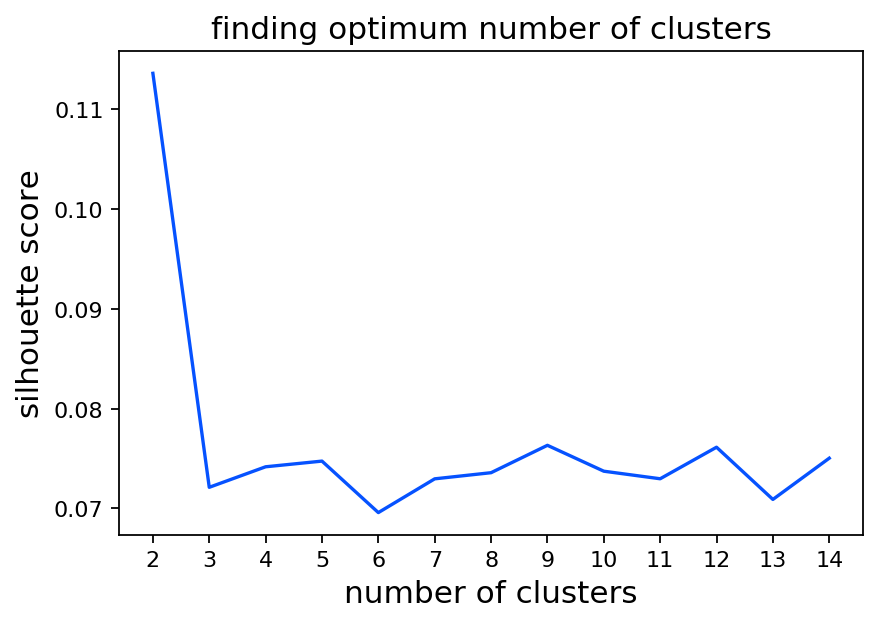

In [39]:
# plot silhouette scores
plt.figure(figsize=(6, 4), dpi=160)
plt.plot([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], sil_scores, color='xkcd:electric blue')
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
plt.xlabel('number of clusters', fontsize=14)
plt.ylabel('silhouette score', fontsize=14)
plt.title('finding optimum number of clusters', fontsize=14)
plt.show()

In [40]:
# cluster using k with max silhoutte score
num_clusters = np.argmax(sil_scores) + 2  # index 0 => 2 clusters

cluster_ids_x, cluster_centers = do_kmeans_clustering(
    X=torch.from_numpy(sentence_embs),
    n_clusters=num_clusters,
    distance='cosine',
    device=device
)















0it [00:00, ?it/s]

k-means clustering on cuda:0..
















0it [00:00, ?it/s, center_shift=683.4906616210938, iteration=1, tol=0.0001]













0it [00:01, ?it/s, center_shift=2.2447845935821533, iteration=2, tol=0.0001]













0it [00:01, ?it/s, center_shift=2.3414456844329834, iteration=3, tol=0.0001]













0it [00:02, ?it/s, center_shift=4.720056056976318, iteration=4, tol=0.0001] 













0it [00:03, ?it/s, center_shift=5.09800386428833, iteration=5, tol=0.0001] 













0it [00:03, ?it/s, center_shift=1.529224157333374, iteration=6, tol=0.0001]













0it [00:04, ?it/s, center_shift=0.20126554369926453, iteration=7, tol=0.0001]













0it [00:04, ?it/s, center_shift=0.030138570815324783, iteration=8, tol=0.0001]













0it [00:05, ?it/s, center_shift=0.005541387014091015, iteration=9, tol=0.0001]













0it [00:06, ?it/s, center_shift=0.0012553191045299172, iteration=10, tol=0.0001]













0it [00:06, ?it/s, center_shift=0.00019759048882406205, iteration=11, tol=0.0001

In [42]:
# UMAP
emb_umap = umap.UMAP(metric='cosine', verbose=True).fit_transform(sentence_embs)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Sat Dec 21 01:02:31 2019 Finding Nearest Neighbors
Sat Dec 21 01:02:31 2019 Building RP forest with 16 trees
Sat Dec 21 01:02:35 2019 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Sat Dec 21 01:03:22 2019 Finished Nearest Neighbor Search
Sat Dec 21 01:03:23 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80

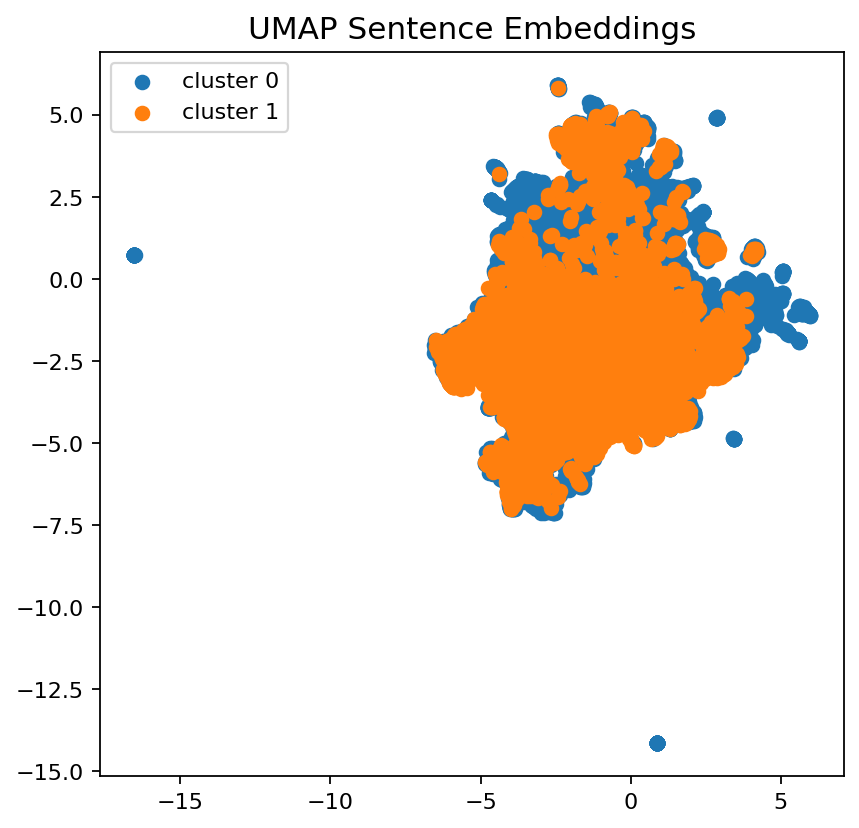

In [45]:
# plot
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
plt.figure(figsize=(6, 6), dpi=160)
for cluster_id in range(num_clusters):
    plt.scatter(
        emb_umap[cluster_ids_x == cluster_id][:, 0],
        emb_umap[cluster_ids_x == cluster_id][:, 1],
        color=cols[cluster_id],
        label=f'cluster {cluster_id}'
    )

plt.title('UMAP Sentence Embeddings', fontsize=14)
plt.legend(fontsize=10)
plt.show()

In [56]:
np.random.choice(sentences[cluster_ids_x == 0], 20, replace=False)

array(['tomic kokkinakis out of wimbledon rodionova advances',
       'mornington island language app',
       'lupin flakes are they the next big superfood',
       'federal budget 2017 defence spending',
       'nick kyrgios roger federer miami masters semi final',
       'tent hotel to be opened on old royal adelaide hospital rooftop',
       'carp clean up underway in canberras south',
       'nsw family daycare victoria subsidies childcare at home',
       'drama on the back nine at the british open',
       'shiraz studies to benefit international marketing',
       'new police squads for regions to combat crime',
       'tasmania government forestry push to hit fiat campaign',
       'ramingining celebrates its first ever naidoc ball',
       'the cases for and against changes to penalty rates',
       'doctor registration', 'we put in a wild kid and we get back a',
       'australia pledges to ratify opcat torture treaty',
       'national dinosaur museum fascinating young and 

In [55]:
np.random.choice(sentences[cluster_ids_x == 1], 20, replace=False)

array(['child water accident borroloola',
       'clive palmer threatens sue queensland premier coal mine',
       'liverpool council fire caused $20m damage',
       'siberian tigers chase down drone in chinese',
       'grand final supporters lose out against the big end of town',
       'rocket man wall street shrugs off trump remarks on north korea',
       'seven west media profit drop tim worner amber harrison affair',
       'rescue underway for couple stranded in gibson desert',
       'russia denies pre election contact with trump team',
       'ten injured after taxi hits pedestrians near boston airport',
       'mexico us relations sour further as presidential',
       'trendy mobility scooters leave mundane models in dust',
       'child safety staff embedded queensland police at risk kids',
       'paris shooting flowers laid as tourists take selfies',
       'sa terror laws for bail and parole to be changed',
       'ben stokes apologises mimicking katie price son disabil